In [1]:
import time
import random
import numpy as np
import importlib

import sys
sys.path.append("../../")

In [2]:
from qiskit import QuantumProgram
import Qconfig

In [3]:
import tools.Experiment_tools as exptool

In [4]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [5]:
qprogram = QuantumProgram()
qprogram.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [6]:
api = qprogram.get_api()

In [7]:
qprogram.available_backends()

['ibmqx4',
 'ibmqx2',
 'ibmqx5',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_unitary_simulator']

In [8]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 24, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 145}

In [9]:
config = qprogram.get_backend_configuration("ibmqx4",list_format=True)
config

{'basis_gates': 'SU2+CNOT',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [2, 4], [3, 2], [3, 4]],
 'description': '5 qubit transmon bowtie chip 3',
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T11:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1'}

In [10]:
n = config['n_qubits']
q = qprogram.create_quantum_register("q",n)
c = qprogram.create_classical_register("c",n)

In [11]:
circuit_names = exptool.all_circuits(qprogram,config['coupling_map'])

In [12]:
rand_perm_names = np.random.permutation(circuit_names)
batches = [list(rand_perm_names[50*j:50*(j+1)]) for j in range(0,1+int(len(circuit_names)/50))]

compiled_qobj_list = [qprogram.compile(batch, 
                                       backend='ibmqx4', 
                                       config=None,
                                       silent=False, 
                                       basis_gates=None, 
                                       coupling_map=None, 
                                       initial_layout=None, 
                                       shots=8192, 
                                       max_credits=5, 
                                       seed=None) for batch in batches]

In [59]:
qprogram.run_batch_async(compiled_qobj_list, wait=10, timeout=30, silent=True, callback=exptool.post_treatment_list)

In [13]:
print(qprogram.get_backend_status("ibmqx4"))
api.get_my_credits()

{'available': True, 'busy': False, 'pending_jobs': 24, 'backend': 'ibmqx4'}


{'maxUserType': 150, 'promotional': 100, 'remaining': 145}

In [14]:
print(exptool.fetch_previous('timed_out.txt',api))
print(exptool.fetch_previous('completed.txt',api))

5
0


In [15]:
dict_cn = exptool.get_qasm_name_dict(compiled_qobj_list)

In [16]:
print(exptool.process_all_api_dumps('data/completed_timed_out.txt','data/already_processed.txt',dict_cn))

5


In [22]:
importlib.reload(exptool)
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [94]:
#exptool.plot_everything_binned('data/Processed_data/')

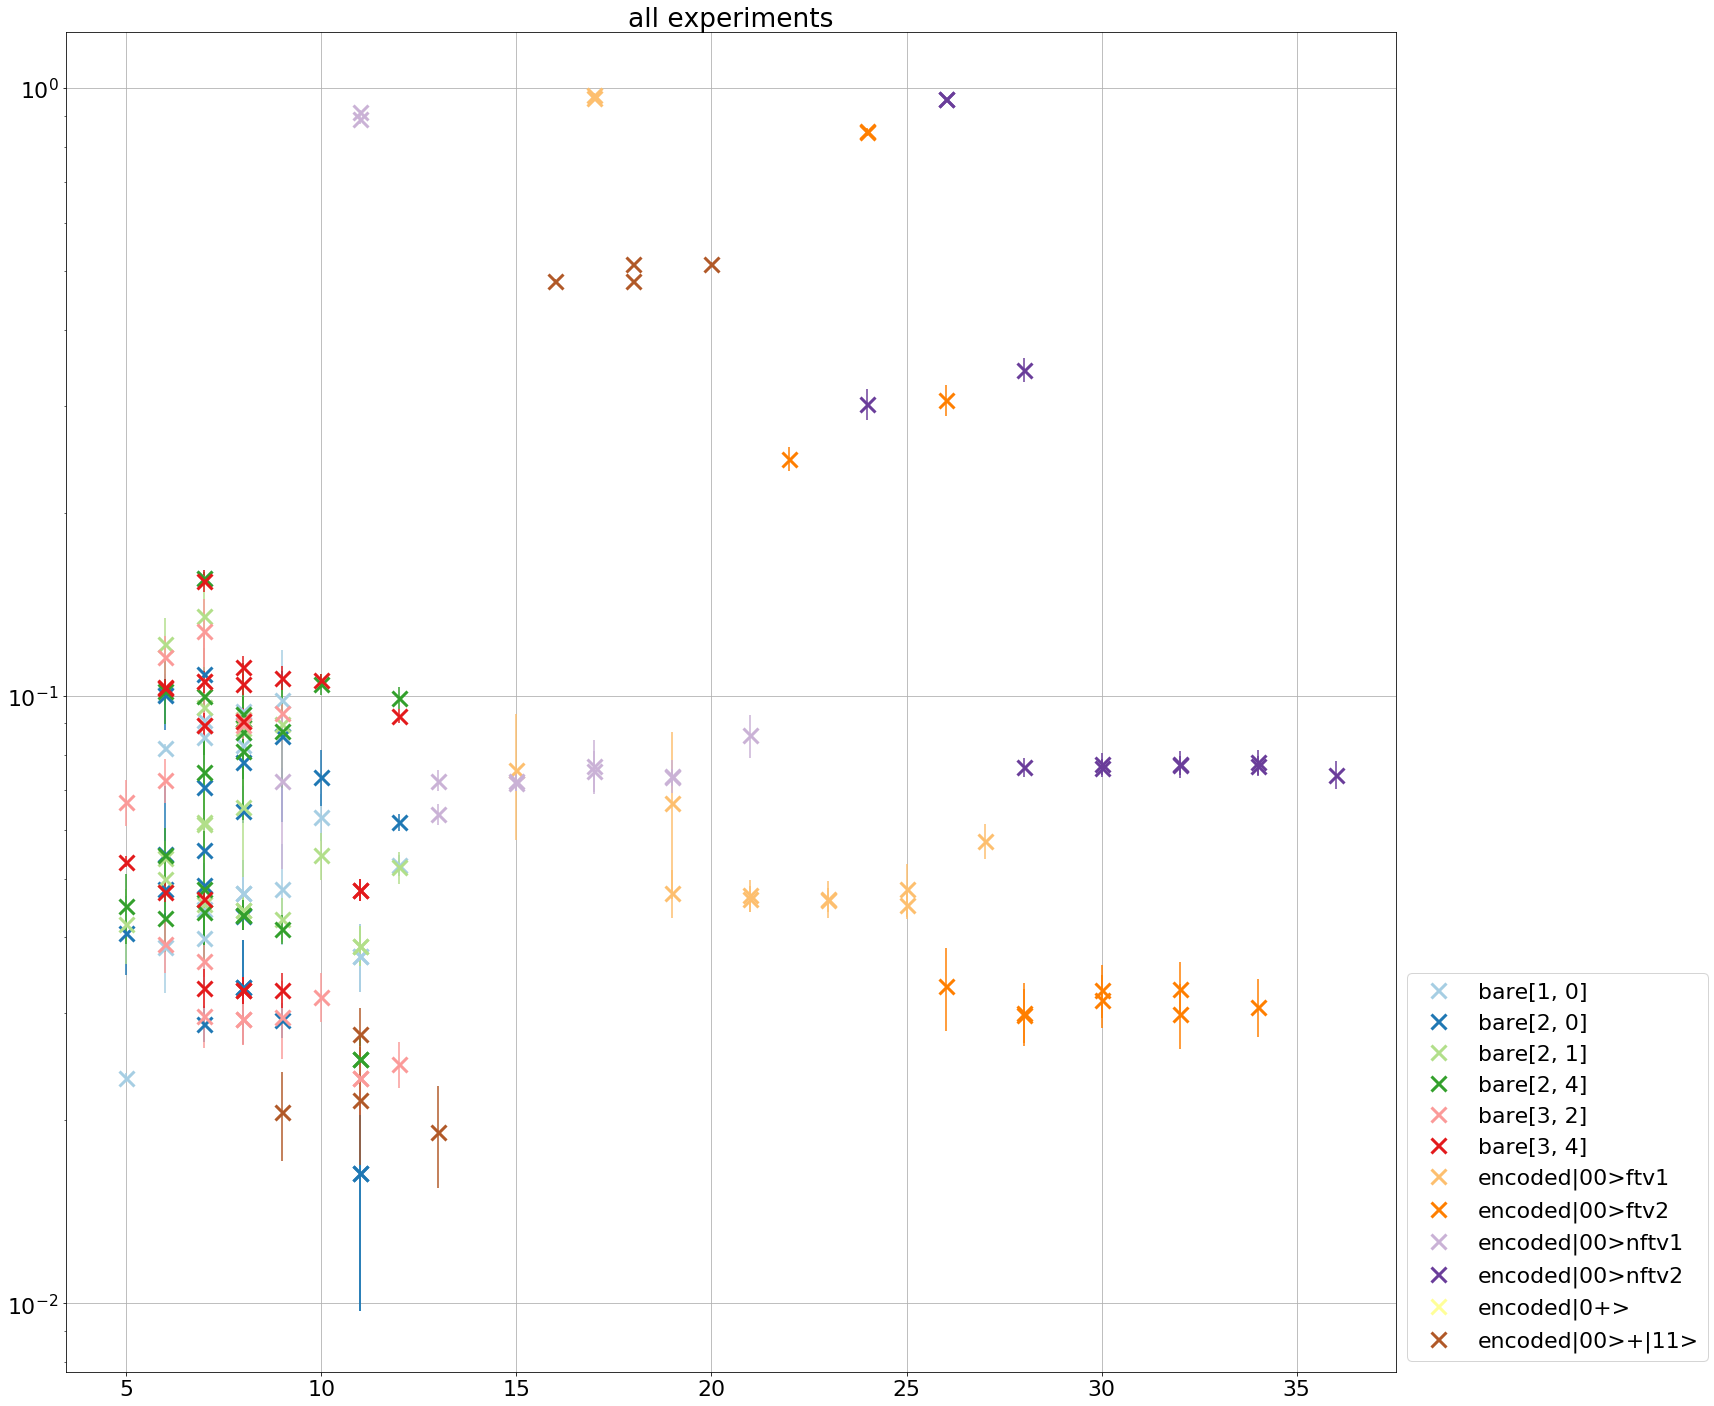

0 23538


In [23]:
exptool.plot_everything_averaged('data/Processed_data/', logscaley=True)

In [88]:
#exptool.plot_everything_averaged_bare_ranked('data/Processed_data/')

In [17]:
import os

In [18]:
importlib.reload(exptool)

<module 'tools.Experiment_tools' from '/Users/cvuillot/Work/Programming/IBMQE/qiskit-sdk-py/examples/experimenting_with_fault_tolerance/tools/Experiment_tools.py'>

In [19]:
file_list = os.listdir('data/Processed_data/')
n=0
for filename in file_list:
    n += exptool.repair_processed_data('data/Processed_data/'+filename, new_ext='')
print(n)

192
